<div style="background-image: url(https://wallpaperaccess.com/full/1614776.jpg); height: 500px; width: 100%; border: 1px solid black;   background-size: cover; color:white;"> 
<br>
<br>
<h1 style="text-align:center;">XGBOOST TRAINING</h1>
<br>
<h2 style='text-align: center;'> Mercado Libre
<h4 style='text-align: center;'> Andrés Felipe Téllez
<h4 style='text-align: center;'>October 2024</h4>
</div>

### **Installing dependencied**

In [55]:
# Load libraries
import numpy as np
import pandas as pd
import pickle
import optuna
import shap
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

### **Loading data**

In [2]:
# Create a schema for the data
schema = {'warranty': 'category',
 'sub_status': 'category',
 'condition': 'category',
 'deal_ids': 'float',
 'base_price': 'float',
 'seller_id': 'category',
 'listing_type_id': 'category',
 'price': 'float',
 'buying_mode': 'category',
 'parent_item_id': 'category',
 'category_id': 'category',
 'official_store_id': 'category',
 'accepts_mercadopago': 'category',
 'original_price': 'float',
 'currency_id': 'category',
 'automatic_relist': 'category',
 'status': 'category',
 'initial_quantity': 'float',
 'sold_quantity': 'float',
 'available_quantity': 'float',
 'seller_address.longitude': 'float',
 'seller_address.id': 'category',
 'seller_address.address_line': 'category',
 'seller_address.latitude': 'float',
 'seller_address.search_location.neighborhood.id': 'category',
 'seller_address.search_location.state.id': 'category',
 'seller_address.search_location.city.id': 'category',
 'seller_address.zip_code': 'category',
 'seller_address.city.id': 'category',
 'seller_address.state.id': 'category',
 'shipping.local_pick_up': 'category',
 'shipping.tags': 'category',
 'shipping.mode': 'category',
 'shipping.free_methods': 'category',
 'seller_contact.phone2': 'category',
 'seller_contact.webpage': 'category',
 'seller_contact.email': 'category',
 'seller_contact.contact': 'category',
 'seller_contact.area_code': 'category',
 'seller_contact.other_info': 'category',
 'seller_contact.phone': 'category',
 'location.open_hours': 'category',
 'location.neighborhood.id': 'category',
 'location.longitude': 'float',
 'location.address_line': 'category',
 'location.latitude': 'float',
 'location.city.id': 'category',
 'location.state.id': 'category',
 'non_mercado_pago_payment_methods.MLAWC': 'category',
 'non_mercado_pago_payment_methods.MLACD': 'category',
 'non_mercado_pago_payment_methods.MLAVS': 'category',
 'non_mercado_pago_payment_methods.MLAMO': 'category',
 'non_mercado_pago_payment_methods.MLADC': 'category',
 'non_mercado_pago_payment_methods.MLAMP': 'category',
 'non_mercado_pago_payment_methods.MLAMC': 'category',
 'non_mercado_pago_payment_methods.MLABC': 'category',
 'non_mercado_pago_payment_methods.MLAOT': 'category',
 'non_mercado_pago_payment_methods.MLAAM': 'category',
 'non_mercado_pago_payment_methods.MLAWT': 'category',
 'non_mercado_pago_payment_methods.MLAVE': 'category',
 'non_mercado_pago_payment_methods.MLATB': 'category',
 'non_mercado_pago_payment_methods.MLAMS': 'category',
 'tags.good_quality_thumbnail': 'category',
 'tags.dragged_visits': 'category',
 'tags.free_relist': 'category',
 'tags.dragged_bids_and_visits': 'category',
 'tags.poor_quality_thumbnail': 'category',
 'pictures.large': 'float',
 'pictures.medium': 'float',
 'pictures.small': 'float',
 'title.new': 'category',
 'video': 'category',
 'seller_address.product_count': 'float'}

In [3]:
# Load data
df = pd.read_csv('../data/clean/output.csv', dtype=schema)

In [4]:
# Drop rows with 70+ missing values
df = df.drop(16647)
df = df.drop(83078)
df = df.drop(92230)
df = df.drop(82275)
df = df.drop(88864)

In [5]:
missing_values_per_row = df.isna().sum(axis=1)
missing_values_per_row = missing_values_per_row.sort_values(ascending=False)

### **Split test and train data**

In [6]:
X = df.drop(columns=['condition'])
y = df['condition'].apply(lambda x: 1 if x == 'new' else 0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### **Simple XGBoost**

In [22]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'objective': 'multi:softmax',
    'num_class': 2,
    'enable_categorical': True
}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

preds = model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
accuracy

0.9144069080442357

In [9]:
# model.get_params()

### **Finding the best hyper-parameters**

In [10]:
def objective(trial):
    '''Use optuna to generate model simulations'''

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 200, 350),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'objective': 'multi:softmax',
        'num_class': 2,
        'enable_categorical': True
    }

    model = xgb.XGBClassifier(**params)

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

In [11]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-10-06 23:52:25,063] A new study created in memory with name: no-name-6a58adc8-d486-4cbb-a500-59c3109743ea


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-06 23:53:54,610] Trial 0 finished with value: 0.9010996235695529 and parameters: {'max_depth': 18, 'learning_rate': 0.4550907472863567, 'n_estimators': 291, 'min_child_weight': 2, 'gamma': 0.5835544449856905, 'subsample': 0.6600693132649261, 'colsample_bytree': 0.5796040146144207, 'reg_alpha': 0.28570538278590896, 'reg_lambda': 0.786727715800476}. Best is trial 0 with value: 0.9010996235695529.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-06 23:55:32,754] Trial 1 finished with value: 0.9021853205251519 and parameters: {'max_depth': 16, 'learning_rate': 0.43166492115042104, 'n_estimators': 221, 'min_child_weight': 4, 'gamma': 0.20559975793323673, 'subsample': 0.879420278081416, 'colsample_bytree': 0.7650942076151215, 'reg_alpha': 0.9265013265904409, 'reg_lambda': 0.881546373754274}. Best is trial 1 with value: 0.9021853205251519.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-06 23:55:54,731] Trial 2 finished with value: 0.9057454345176518 and parameters: {'max_depth': 3, 'learning_rate': 0.3591309391303914, 'n_estimators': 281, 'min_child_weight': 1, 'gamma': 0.5995668539286694, 'subsample': 0.6811152095769262, 'colsample_bytree': 0.6583144341001974, 'reg_alpha': 0.9177707295097484, 'reg_lambda': 0.6491925628506626}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-06 23:56:58,311] Trial 3 finished with value: 0.9011248646189931 and parameters: {'max_depth': 9, 'learning_rate': 0.24301933428254463, 'n_estimators': 236, 'min_child_weight': 5, 'gamma': 0.8888879546811073, 'subsample': 0.8715952447868842, 'colsample_bytree': 0.7101118161093884, 'reg_alpha': 0.05860853882949363, 'reg_lambda': 0.461015601334538}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-06 23:59:51,308] Trial 4 finished with value: 0.9021979487001236 and parameters: {'max_depth': 12, 'learning_rate': 0.1383989290548518, 'n_estimators': 269, 'min_child_weight': 6, 'gamma': 0.34035471868102424, 'subsample': 0.8322010918292285, 'colsample_bytree': 0.6935619024396569, 'reg_alpha': 0.4209054752689827, 'reg_lambda': 0.0843306223304985}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:00:50,952] Trial 5 finished with value: 0.9031069109737083 and parameters: {'max_depth': 6, 'learning_rate': 0.27516942099281394, 'n_estimators': 348, 'min_child_weight': 3, 'gamma': 0.5957682878561799, 'subsample': 0.9005336902889854, 'colsample_bytree': 0.6060099623836379, 'reg_alpha': 0.3140172211507566, 'reg_lambda': 0.6427606325400499}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:02:03,871] Trial 6 finished with value: 0.8992438288416897 and parameters: {'max_depth': 7, 'learning_rate': 0.30147236961636265, 'n_estimators': 305, 'min_child_weight': 9, 'gamma': 0.23946725741860264, 'subsample': 0.7576125169415101, 'colsample_bytree': 0.5566778461306368, 'reg_alpha': 0.4986793943968011, 'reg_lambda': 0.5954156599453616}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:04:21,750] Trial 7 finished with value: 0.8986252074889332 and parameters: {'max_depth': 10, 'learning_rate': 0.30381166087128325, 'n_estimators': 212, 'min_child_weight': 5, 'gamma': 0.07145662989315851, 'subsample': 0.5552380585220393, 'colsample_bytree': 0.6951511180605645, 'reg_alpha': 0.31159763566993914, 'reg_lambda': 0.9176517758491494}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:05:53,445] Trial 8 finished with value: 0.9006577636746916 and parameters: {'max_depth': 18, 'learning_rate': 0.20547833402180113, 'n_estimators': 250, 'min_child_weight': 5, 'gamma': 0.9066674064926142, 'subsample': 0.7162610129800939, 'colsample_bytree': 0.6381336466220824, 'reg_alpha': 0.5703281604447585, 'reg_lambda': 0.11570604057694618}. Best is trial 2 with value: 0.9057454345176518.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:08:06,287] Trial 9 finished with value: 0.9077401090473391 and parameters: {'max_depth': 14, 'learning_rate': 0.1922986056410134, 'n_estimators': 339, 'min_child_weight': 2, 'gamma': 0.4992024432773057, 'subsample': 0.8773284473435227, 'colsample_bytree': 0.577262223465849, 'reg_alpha': 0.08053621433193425, 'reg_lambda': 0.6583004674815662}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:14:09,328] Trial 10 finished with value: 0.8977162351743931 and parameters: {'max_depth': 14, 'learning_rate': 0.0231423075536914, 'n_estimators': 349, 'min_child_weight': 9, 'gamma': 0.44482385481163245, 'subsample': 0.9947659543917365, 'colsample_bytree': 0.504108649314715, 'reg_alpha': 0.006639383162338544, 'reg_lambda': 0.378537158297422}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:14:18,998] Trial 11 finished with value: 0.9002916537040323 and parameters: {'max_depth': 1, 'learning_rate': 0.37696826575310965, 'n_estimators': 317, 'min_child_weight': 1, 'gamma': 0.7014268900038108, 'subsample': 0.6002849077649418, 'colsample_bytree': 0.5299935473916032, 'reg_alpha': 0.9410475191088886, 'reg_lambda': 0.7162487154739636}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:14:29,909] Trial 12 finished with value: 0.8960371641313073 and parameters: {'max_depth': 1, 'learning_rate': 0.11839870914021167, 'n_estimators': 321, 'min_child_weight': 1, 'gamma': 0.7166286968493131, 'subsample': 0.7834297861746182, 'colsample_bytree': 0.636313160227179, 'reg_alpha': 0.7358822713369357, 'reg_lambda': 0.3851897553039125}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:14:53,387] Trial 13 finished with value: 0.9023494437671199 and parameters: {'max_depth': 4, 'learning_rate': 0.3782625880784648, 'n_estimators': 276, 'min_child_weight': 3, 'gamma': 0.42727087838493155, 'subsample': 0.9746692415728845, 'colsample_bytree': 0.5973403439434388, 'reg_alpha': 0.7516167127289073, 'reg_lambda': 0.9997309977763762}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:17:22,716] Trial 14 finished with value: 0.8993195539025733 and parameters: {'max_depth': 13, 'learning_rate': 0.16844658469722384, 'n_estimators': 327, 'min_child_weight': 7, 'gamma': 0.7516165307883859, 'subsample': 0.6656830314590674, 'colsample_bytree': 0.7913980057521368, 'reg_alpha': 0.17234466601054071, 'reg_lambda': 0.5363986055540075}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:18:39,376] Trial 15 finished with value: 0.9029554178192751 and parameters: {'max_depth': 20, 'learning_rate': 0.49872640935912815, 'n_estimators': 261, 'min_child_weight': 2, 'gamma': 0.50723054685009, 'subsample': 0.8039107909172318, 'colsample_bytree': 0.6625756919134023, 'reg_alpha': 0.6754485109042213, 'reg_lambda': 0.2894384317374784}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:19:15,182] Trial 16 finished with value: 0.9047354717076104 and parameters: {'max_depth': 4, 'learning_rate': 0.07460221976607892, 'n_estimators': 291, 'min_child_weight': 1, 'gamma': 0.5818663864113875, 'subsample': 0.5122850287075589, 'colsample_bytree': 0.7365144627659106, 'reg_alpha': 0.8848446992816686, 'reg_lambda': 0.753931908151886}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:21:15,694] Trial 17 finished with value: 0.9028291877087559 and parameters: {'max_depth': 15, 'learning_rate': 0.35160066890963493, 'n_estimators': 333, 'min_child_weight': 3, 'gamma': 0.35333150278673464, 'subsample': 0.7001478385581786, 'colsample_bytree': 0.5590696298866829, 'reg_alpha': 0.15488601281054443, 'reg_lambda': 0.6535246964414699}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:22:03,471] Trial 18 finished with value: 0.9058085634389927 and parameters: {'max_depth': 8, 'learning_rate': 0.22078617870357864, 'n_estimators': 292, 'min_child_weight': 2, 'gamma': 0.8239883867017583, 'subsample': 0.9302842619040369, 'colsample_bytree': 0.6229749064755103, 'reg_alpha': 0.6109994756543686, 'reg_lambda': 0.8373882710547526}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:22:45,687] Trial 19 finished with value: 0.8976909855184196 and parameters: {'max_depth': 8, 'learning_rate': 0.21191174420436312, 'n_estimators': 313, 'min_child_weight': 7, 'gamma': 0.9746974614754498, 'subsample': 0.9290779456057382, 'colsample_bytree': 0.6182106539280174, 'reg_alpha': 0.6057558977589952, 'reg_lambda': 0.892419737038695}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:24:14,308] Trial 20 finished with value: 0.9023873062975616 and parameters: {'max_depth': 11, 'learning_rate': 0.0968427566738862, 'n_estimators': 338, 'min_child_weight': 4, 'gamma': 0.8109686791463926, 'subsample': 0.9508782430962907, 'colsample_bytree': 0.5683671230659242, 'reg_alpha': 0.4358819798535983, 'reg_lambda': 0.7615194769886362}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:24:47,034] Trial 21 finished with value: 0.9035740147868543 and parameters: {'max_depth': 4, 'learning_rate': 0.18341508618477145, 'n_estimators': 290, 'min_child_weight': 2, 'gamma': 0.6300320264731638, 'subsample': 0.8580383901113153, 'colsample_bytree': 0.6779725868029216, 'reg_alpha': 0.8478114881505832, 'reg_lambda': 0.5349128059980351}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:25:57,991] Trial 22 finished with value: 0.9066417757883757 and parameters: {'max_depth': 11, 'learning_rate': 0.24898658259184914, 'n_estimators': 304, 'min_child_weight': 2, 'gamma': 0.5039951856334567, 'subsample': 0.9130676766871668, 'colsample_bytree': 0.6443720525540869, 'reg_alpha': 0.78370256738937, 'reg_lambda': 0.8094545375646118}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:27:06,379] Trial 23 finished with value: 0.9043188762910854 and parameters: {'max_depth': 11, 'learning_rate': 0.2376536810790849, 'n_estimators': 304, 'min_child_weight': 3, 'gamma': 0.49039867216072924, 'subsample': 0.9211241257109706, 'colsample_bytree': 0.6125459187648903, 'reg_alpha': 0.7689578225507572, 'reg_lambda': 0.8494096867438753}. Best is trial 9 with value: 0.9077401090473391.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:31:20,312] Trial 24 finished with value: 0.9083586969302441 and parameters: {'max_depth': 13, 'learning_rate': 0.16324937120610417, 'n_estimators': 301, 'min_child_weight': 2, 'gamma': 0.032269897090430155, 'subsample': 0.8279612162222534, 'colsample_bytree': 0.5335882221688506, 'reg_alpha': 0.6178146365245388, 'reg_lambda': 0.960281242260524}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:36:25,220] Trial 25 finished with value: 0.9042178690606585 and parameters: {'max_depth': 16, 'learning_rate': 0.152393793706978, 'n_estimators': 307, 'min_child_weight': 4, 'gamma': 0.044551476210111296, 'subsample': 0.8338990580861956, 'colsample_bytree': 0.5225624363724215, 'reg_alpha': 0.7938383755722794, 'reg_lambda': 0.9934272821306517}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:41:10,241] Trial 26 finished with value: 0.9077906045341599 and parameters: {'max_depth': 13, 'learning_rate': 0.05507941085894083, 'n_estimators': 328, 'min_child_weight': 2, 'gamma': 0.1458387725556261, 'subsample': 0.8066113011992135, 'colsample_bytree': 0.5388884644954105, 'reg_alpha': 0.6809324555524845, 'reg_lambda': 0.9247659522262749}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:45:48,851] Trial 27 finished with value: 0.8962265413325153 and parameters: {'max_depth': 13, 'learning_rate': 0.02893486482597729, 'n_estimators': 338, 'min_child_weight': 10, 'gamma': 0.115091980129674, 'subsample': 0.7379321057289829, 'colsample_bytree': 0.5332508684063764, 'reg_alpha': 0.6737559214428795, 'reg_lambda': 0.9381698455622607}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:51:13,731] Trial 28 finished with value: 0.9051773473811157 and parameters: {'max_depth': 15, 'learning_rate': 0.06317388160815475, 'n_estimators': 327, 'min_child_weight': 4, 'gamma': 0.19971553098215677, 'subsample': 0.7976720226861284, 'colsample_bytree': 0.5027135075276296, 'reg_alpha': 0.5022928713175834, 'reg_lambda': 0.1884711905906657}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 00:56:14,696] Trial 29 finished with value: 0.9064650296309839 and parameters: {'max_depth': 18, 'learning_rate': 0.11751091341530075, 'n_estimators': 337, 'min_child_weight': 3, 'gamma': 0.13240685918187906, 'subsample': 0.8289819966380245, 'colsample_bytree': 0.5854816504841895, 'reg_alpha': 0.9953161522318774, 'reg_lambda': 0.7304669137624915}. Best is trial 24 with value: 0.9083586969302441.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 01:06:02,428] Trial 30 finished with value: 0.9089520662363236 and parameters: {'max_depth': 17, 'learning_rate': 0.05491391747543228, 'n_estimators': 321, 'min_child_weight': 2, 'gamma': 0.008058777486651934, 'subsample': 0.761634284995113, 'colsample_bytree': 0.5444469530251802, 'reg_alpha': 0.3868751370672936, 'reg_lambda': 0.9494575952471607}. Best is trial 30 with value: 0.9089520662363236.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 01:16:18,200] Trial 31 finished with value: 0.9085733223530035 and parameters: {'max_depth': 17, 'learning_rate': 0.050440412768508774, 'n_estimators': 324, 'min_child_weight': 2, 'gamma': 0.024273207353421672, 'subsample': 0.7504210013725321, 'colsample_bytree': 0.5475755911794953, 'reg_alpha': 0.21518644412223162, 'reg_lambda': 0.9533737984792615}. Best is trial 30 with value: 0.9089520662363236.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 01:29:41,106] Trial 32 finished with value: 0.9112118482876506 and parameters: {'max_depth': 20, 'learning_rate': 0.06275724843725808, 'n_estimators': 320, 'min_child_weight': 1, 'gamma': 0.004330515895104964, 'subsample': 0.7580242401046595, 'colsample_bytree': 0.5468938603301621, 'reg_alpha': 0.2539488421853695, 'reg_lambda': 0.9497463401460314}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 01:39:16,966] Trial 33 finished with value: 0.91054274244531 and parameters: {'max_depth': 20, 'learning_rate': 0.08917097895249793, 'n_estimators': 316, 'min_child_weight': 1, 'gamma': 0.034562830135072595, 'subsample': 0.6345460483497943, 'colsample_bytree': 0.5518169552641541, 'reg_alpha': 0.23943592260880883, 'reg_lambda': 0.97267699441766}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 01:52:57,104] Trial 34 finished with value: 0.9109719775121844 and parameters: {'max_depth': 20, 'learning_rate': 0.017137593607628787, 'n_estimators': 319, 'min_child_weight': 1, 'gamma': 0.009038008848178378, 'subsample': 0.6272922161198686, 'colsample_bytree': 0.5507027135466255, 'reg_alpha': 0.24574986160495554, 'reg_lambda': 0.8676827408145754}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:01:06,387] Trial 35 finished with value: 0.9091792940144551 and parameters: {'max_depth': 20, 'learning_rate': 0.013181326450548377, 'n_estimators': 283, 'min_child_weight': 1, 'gamma': 0.24163066286649304, 'subsample': 0.6001446693625062, 'colsample_bytree': 0.5868553008907895, 'reg_alpha': 0.3786267063591719, 'reg_lambda': 0.866826789480872}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:06:01,393] Trial 36 finished with value: 0.9110224820836793 and parameters: {'max_depth': 20, 'learning_rate': 0.09388286490341717, 'n_estimators': 283, 'min_child_weight': 1, 'gamma': 0.2521553028239867, 'subsample': 0.6255198722963471, 'colsample_bytree': 0.592402369776946, 'reg_alpha': 0.24883321032423872, 'reg_lambda': 0.8528472982924047}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:09:51,931] Trial 37 finished with value: 0.9105174961363215 and parameters: {'max_depth': 19, 'learning_rate': 0.09426668823981062, 'n_estimators': 240, 'min_child_weight': 1, 'gamma': 0.3050238009235414, 'subsample': 0.6220830106344978, 'colsample_bytree': 0.5689047191607961, 'reg_alpha': 0.252068281665235, 'reg_lambda': 0.8024104064874317}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:15:32,084] Trial 38 finished with value: 0.9106689883344735 and parameters: {'max_depth': 19, 'learning_rate': 0.12354223324148036, 'n_estimators': 261, 'min_child_weight': 1, 'gamma': 0.09404728026306614, 'subsample': 0.6493820370197716, 'colsample_bytree': 0.5128955693788347, 'reg_alpha': 0.13272178738689816, 'reg_lambda': 0.8829267837977165}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:20:51,398] Trial 39 finished with value: 0.9099746452678185 and parameters: {'max_depth': 19, 'learning_rate': 0.1296796102213496, 'n_estimators': 259, 'min_child_weight': 1, 'gamma': 0.08487045949626248, 'subsample': 0.562636591342419, 'colsample_bytree': 0.5190272540107125, 'reg_alpha': 0.337669717046829, 'reg_lambda': 0.6993862874335939}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:28:40,895] Trial 40 finished with value: 0.9045082367573678 and parameters: {'max_depth': 19, 'learning_rate': 0.031843456940413364, 'n_estimators': 223, 'min_child_weight': 3, 'gamma': 0.17132906485635582, 'subsample': 0.6863557753692203, 'colsample_bytree': 0.520295517376566, 'reg_alpha': 0.12673996294114714, 'reg_lambda': 0.8747266318570625}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:35:38,123] Trial 41 finished with value: 0.9102145103055959 and parameters: {'max_depth': 20, 'learning_rate': 0.09064946315623798, 'n_estimators': 268, 'min_child_weight': 1, 'gamma': 0.09449061945966808, 'subsample': 0.6414133259065667, 'colsample_bytree': 0.5579828398616236, 'reg_alpha': 0.2335041982711693, 'reg_lambda': 0.806708483162621}. Best is trial 32 with value: 0.9112118482876506.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:39:28,658] Trial 42 finished with value: 0.9115905797393116 and parameters: {'max_depth': 17, 'learning_rate': 0.07971424152862015, 'n_estimators': 245, 'min_child_weight': 1, 'gamma': 0.2738134359033649, 'subsample': 0.6456653957614193, 'colsample_bytree': 0.509296736987739, 'reg_alpha': 0.2714477696492967, 'reg_lambda': 0.8831954373264005}. Best is trial 42 with value: 0.9115905797393116.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:43:03,172] Trial 43 finished with value: 0.9114517142817093 and parameters: {'max_depth': 17, 'learning_rate': 0.10976375122294371, 'n_estimators': 244, 'min_child_weight': 1, 'gamma': 0.2714177474873713, 'subsample': 0.7180014881097919, 'colsample_bytree': 0.5103217335065099, 'reg_alpha': 0.08636668242000375, 'reg_lambda': 0.8860489577099402}. Best is trial 42 with value: 0.9115905797393116.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:48:23,929] Trial 44 finished with value: 0.9112749647773324 and parameters: {'max_depth': 17, 'learning_rate': 0.036308449945482324, 'n_estimators': 236, 'min_child_weight': 1, 'gamma': 0.28074727624882556, 'subsample': 0.7146648385255326, 'colsample_bytree': 0.5012347620111973, 'reg_alpha': 0.07543099781512239, 'reg_lambda': 0.7751762886927301}. Best is trial 42 with value: 0.9115905797393116.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:53:51,814] Trial 45 finished with value: 0.9118809445671765 and parameters: {'max_depth': 17, 'learning_rate': 0.04157662628497938, 'n_estimators': 237, 'min_child_weight': 1, 'gamma': 0.27478348966202637, 'subsample': 0.713912663609672, 'colsample_bytree': 0.5052688805519626, 'reg_alpha': 0.0041858380380201815, 'reg_lambda': 0.7759354151038396}. Best is trial 45 with value: 0.9118809445671765.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 02:59:18,125] Trial 46 finished with value: 0.9015162175516555 and parameters: {'max_depth': 17, 'learning_rate': 0.040614581483509125, 'n_estimators': 229, 'min_child_weight': 6, 'gamma': 0.35686575426833955, 'subsample': 0.7190180402382732, 'colsample_bytree': 0.5066360761305544, 'reg_alpha': 0.015145778687963733, 'reg_lambda': 0.0003866222736128022}. Best is trial 45 with value: 0.9118809445671765.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 03:03:08,092] Trial 47 finished with value: 0.9077906030997377 and parameters: {'max_depth': 16, 'learning_rate': 0.07625486316363086, 'n_estimators': 200, 'min_child_weight': 2, 'gamma': 0.31549517105175784, 'subsample': 0.6755835697331426, 'colsample_bytree': 0.506284030968379, 'reg_alpha': 0.07224225044751963, 'reg_lambda': 0.6248328486952562}. Best is trial 45 with value: 0.9118809445671765.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 03:05:37,752] Trial 48 finished with value: 0.9101513823405364 and parameters: {'max_depth': 15, 'learning_rate': 0.1412508803440929, 'n_estimators': 243, 'min_child_weight': 1, 'gamma': 0.40559987072242165, 'subsample': 0.7200341625922887, 'colsample_bytree': 0.5269377095286958, 'reg_alpha': 0.0410491209798897, 'reg_lambda': 0.6980301212766926}. Best is trial 45 with value: 0.9118809445671765.


/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/_n/r6v_878172qgdkkhlq7tz9pc0000gq/T/ipykernel_55586/2969005371.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.8),


[I 2024-10-07 03:10:27,287] Trial 49 finished with value: 0.906553421118098 and parameters: {'max_depth': 18, 'learning_rate': 0.07283057446751673, 'n_estimators': 232, 'min_child_weight': 3, 'gamma': 0.27324113413336043, 'subsample': 0.7705919477529705, 'colsample_bytree': 0.5011762590663685, 'reg_alpha': 0.18949199617352003, 'reg_lambda': 0.7733250510204243}. Best is trial 45 with value: 0.9118809445671765.


In [12]:
study.best_params

{'max_depth': 17,
 'learning_rate': 0.04157662628497938,
 'n_estimators': 237,
 'min_child_weight': 1,
 'gamma': 0.27478348966202637,
 'subsample': 0.713912663609672,
 'colsample_bytree': 0.5052688805519626,
 'reg_alpha': 0.0041858380380201815,
 'reg_lambda': 0.7759354151038396}

### **Best params**

In [24]:
# best_params = {'max_depth': 10, 
#                'learning_rate': 0.13340751917009136, 
#                'n_estimators': 262, 
#                'min_child_weight': 1, 
#                'gamma': 0.21217290321736526, 
#                'subsample': 0.9891830695807934, 
#                'colsample_bytree': 0.5269533861847706, 
#                'reg_alpha': 0.7767916720825168, 
#                'reg_lambda': 0.4022821656006917,
#                'enable_categorical': True,
#                }

# model = xgb.XGBClassifier(**best_params)
# model.fit(X_train, y_train)

In [13]:
best_params = {'max_depth': 17,
    'learning_rate': 0.04157662628497938,
    'n_estimators': 237,
    'min_child_weight': 1,
    'gamma': 0.27478348966202637,
    'subsample': 0.713912663609672,
    'colsample_bytree': 0.5052688805519626,
    'reg_alpha': 0.0041858380380201815,
    'reg_lambda': 0.7759354151038396,
    'enable_categorical': True,
    }

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5052688805519626, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.27478348966202637,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04157662628497938,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=237, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### **Model Metrics**

#### **Accuracy**

In [15]:
# X_test
# preds = model.predict(X_test)
accuracy_X_test = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy').mean()

# X
accuracy_X = cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

print(accuracy_X_test)
print(accuracy_X)

0.883956976215725
0.8918633716633138


#### **Precision**

In [16]:
# X_test
# preds = model.predict(X_test)
precision_X_test = cross_val_score(model, X_test, y_test, cv=3, scoring='precision').mean()

# X
precision_X = cross_val_score(model, X, y, cv=3, scoring='precision').mean()

print(precision_X_test)
print(precision_X)

0.8957068529446709
0.8825279574520312


In [17]:
conf_matrix = confusion_matrix(y_test, preds)
conf_matrix

array([[8365,  840],
       [ 855, 9743]])

### **Store model**

In [25]:
# Save the model
with open('../models/xgboost_all_variables.pickle', 'wb') as f:
    pickle.dump(model, f)

### **Loading model**

In [ ]:
# Load the model
with open('../models/xgboost_all_variables.pickle', 'rb') as f:
    model = pickle.load(f)

### **Evaluation**

In [18]:
# Create explainer
explainer = shap.Explainer(model)

# Get hsap values
shap_values = explainer(X_test)

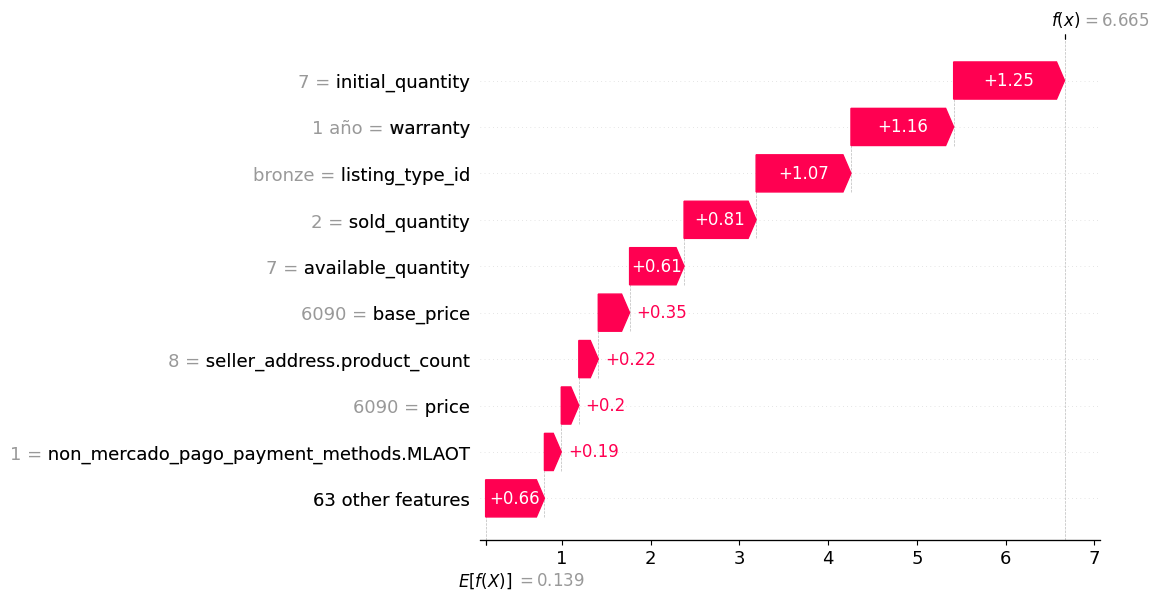

In [53]:
shap.plots.waterfall(shap_values[1])

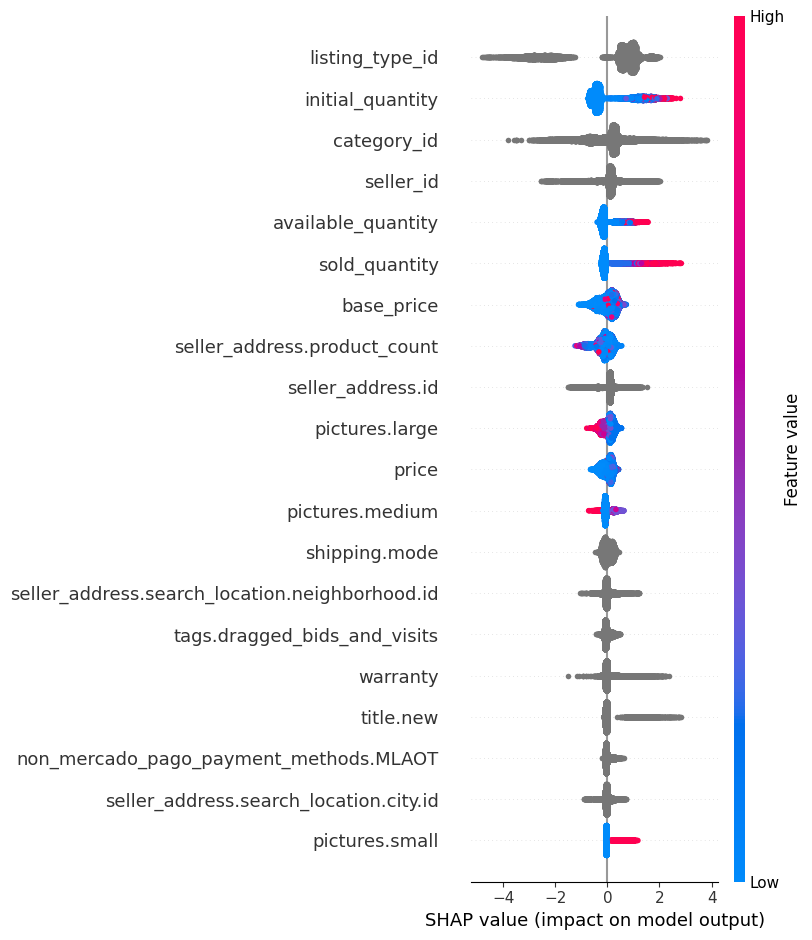

In [20]:
# Visualize the SHAP values for the entire dataset
shap.summary_plot(shap_values, X_test)

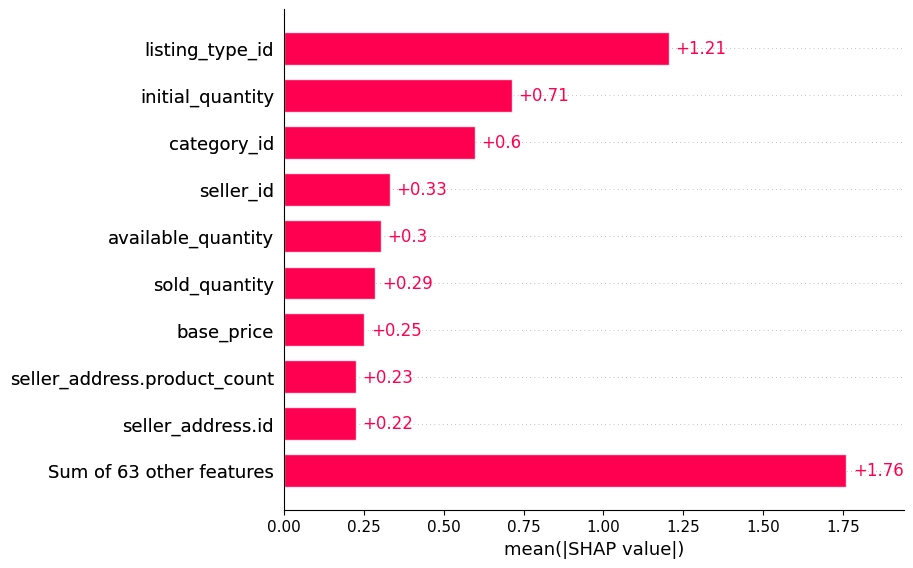

In [29]:
# Valor absoluto de los shap values
shap_values_abs = np.abs(shap_values.values)

shap_values_abs_obj = shap.Explanation(values=shap_values_abs, 
                                       base_values=shap_values.base_values, 
                                       data=shap_values.data, 
                                       feature_names=shap_values.feature_names)

shap.plots.bar(shap_values_abs_obj)

### **Selection of variables**

In [30]:
# Create a df for the shap values
shap_values_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)

In [36]:
# Identify feature with shap value of 0
pd.set_option('display.max_columns', None)
shap_values_df.head()

,warranty,sub_status,deal_ids,base_price,seller_id,listing_type_id,price,buying_mode,parent_item_id,category_id,official_store_id,accepts_mercadopago,original_price,currency_id,automatic_relist,status,initial_quantity,sold_quantity,available_quantity,seller_address.longitude,seller_address.id,seller_address.address_line,seller_address.latitude,seller_address.search_location.neighborhood.id,seller_address.search_location.state.id,seller_address.search_location.city.id,seller_address.zip_code,seller_address.city.id,seller_address.state.id,shipping.local_pick_up,shipping.tags,shipping.mode,shipping.free_methods,seller_contact.phone2,seller_contact.webpage,seller_contact.email,seller_contact.contact,seller_contact.area_code,seller_contact.other_info,seller_contact.phone,location.open_hours,location.neighborhood.id,location.longitude,location.address_line,location.latitude,location.city.id,location.state.id,non_mercado_pago_payment_methods.MLAWC,non_mercado_pago_payment_methods.MLACD,non_mercado_pago_payment_methods.MLAVS,non_mercado_pago_payment_methods.MLAMO,non_mercado_pago_payment_methods.MLADC,non_mercado_pago_payment_methods.MLAMP,non_mercado_pago_payment_methods.MLAMC,non_mercado_pago_payment_methods.MLABC,non_mercado_pago_payment_methods.MLAOT,non_mercado_pago_payment_methods.MLAAM,non_mercado_pago_payment_methods.MLAWT,non_mercado_pago_payment_methods.MLAVE,non_mercado_pago_payment_methods.MLATB,non_mercado_pago_payment_methods.MLAMS,tags.good_quality_thumbnail,tags.dragged_visits,tags.free_relist,tags.dragged_bids_and_visits,tags.poor_quality_thumbnail,pictures.large,pictures.medium,pictures.small,title.new,video,seller_address.product_count
0,-0.032497,-0.000035,0.0,-0.019436,0.079400,-3.189033,0.007691,0.006574,-0.000301,0.191822,0.000003,0.001013,0.0,-0.000189,-0.006823,-0.002735,-0.330307,-0.105878,-0.123087,-0.033150,0.065501,0.000205,-0.078614,0.181907,-0.043359,-0.091939,0.000069,-0.056915,-0.008281,0.012032,0.0,-0.010195,-0.005550,0.000241,-0.000007,-0.002372,0.006006,0.000054,0.0,0.0,0.0,-0.001213,-0.000048,0.0,-0.000144,0.001197,0.004173,0.003860,-0.000112,4.295149e-06,-0.028913,-0.000016,-0.000032,-0.000019,0.000011,-0.041784,-0.000025,0.001144,-0.000064,-0.026707,-0.000051,0.000569,-0.001824,0.001116,-0.185743,0.0,0.229320,-0.066078,-0.036882,-0.050483,-0.004813,-0.312170
1,1.157464,0.000440,0.0,0.353068,0.132633,1.069192,0.197681,0.005487,-0.000246,0.069519,0.000057,0.000991,0.0,-0.000086,-0.006428,0.005312,1.250024,0.812375,0.614149,0.071757,0.102656,0.000149,0.054515,-0.016950,0.029031,0.122424,-0.000218,0.123535,0.008732,0.014660,0.0,-0.134156,-0.004230,0.000314,0.000028,-0.000894,0.008157,0.000006,0.0,0.0,0.0,-0.001108,0.000005,0.0,-0.000058,0.001930,0.003533,0.009795,0.000024,-1.604759e-06,-0.009758,-0.000039,-0.000023,-0.000062,0.000316,0.189919,-0.000028,0.000756,-0.000071,0.099042,-0.000108,0.001424,-0.001697,0.001351,-0.023799,0.0,0.079031,-0.033158,-0.020019,-0.030758,-0.001067,0.219529
2,-0.023745,-0.000323,0.0,0.287946,0.756335,1.020277,0.211210,0.005160,-0.000300,-0.302572,0.000003,0.001089,0.0,0.000141,-0.003983,-0.003090,-0.309376,0.469019,-0.123003,0.006566,0.430903,0.000133,0.082121,0.023226,0.011771,0.015934,-0.000591,0.063359,-0.006938,-0.042583,0.0,0.146279,0.452013,0.000219,-0.000006,-0.001818,0.012553,0.000224,0.0,0.0,0.0,-0.000945,0.000289,0.0,0.000336,0.001058,0.004322,0.011749,-0.000121,8.187064e-06,-0.020417,-0.000013,-0.000022,-0.000048,0.000027,-0.047585,-0.000046,0.001062,-0.000061,-0.069615,-0.000075,0.001645,-0.001419,0.001267,-0.067110,0.0,0.348961,-0.007405,0.817269,-0.046524,-0.003314,0.036449
3,-0.039933,-0.000064,0.0,0.001748,0.115369,0.956281,-0.048857,0.012752,-0.000362,2.114824,0.000007,0.001871,0.0,-0.000129,-0.008363,0.004284,0.528073,0.264215,-0.118590,0.095058,0.093449,0.000140,-0.003187,-0.025215,0.033103,0.046428,-0.000432,0.024924,0.007791,0.018908,0.0,-0.141218,-0.002708,0.000442,0.000184,0.000618,0.008596,-0.000272,0.0,0.0,0.0,-0.001160,-0.000239,0.0,-0.000132,0

In [42]:
cols_to_drop = ['deal_ids', 'tags.poor_quality_thumbnail', 'original_price', 'shipping.tags', 'seller_contact.other_info',	'seller_contact.phone',	'location.open_hours', 'location.address_line', 'tags.poor_quality_thumbnail']

### **Best model**

In [43]:
# Removed variables with Shapley value of 0
df_cleaned = df.drop(columns=cols_to_drop)

In [44]:
X_best_model = df_cleaned.drop(columns=['condition'])
y_best_model = df_cleaned['condition'].apply(lambda x: 1 if x == 'new' else 0)

In [45]:
# Drop rows with 70+ missing values
df_cleaned = df_cleaned.drop(16648)
df_cleaned = df_cleaned.drop(82276)
df_cleaned = df_cleaned.drop(92231)
df_cleaned = df_cleaned.drop(83079)
df_cleaned = df_cleaned.drop(88865)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_best_model, y_best_model, test_size=0.2)

In [48]:
best_params = {'max_depth': 17,
    'learning_rate': 0.04157662628497938,
    'n_estimators': 237,
    'min_child_weight': 1,
    'gamma': 0.27478348966202637,
    'subsample': 0.713912663609672,
    'colsample_bytree': 0.5052688805519626,
    'reg_alpha': 0.0041858380380201815,
    'reg_lambda': 0.7759354151038396,
    'enable_categorical': True,
    }

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5052688805519626, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.27478348966202637,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04157662628497938,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=237, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### **Evaluation best model**

In [49]:
# X_test
# preds = model.predict(X_test)
accuracy_X_test = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy').mean()

# X
accuracy_X = cross_val_score(model, X, y, cv=3, scoring='accuracy').mean()

print(accuracy_X_test)
print(accuracy_X)

0.8881482603645913
0.8918633716633138


In [50]:
# X_test
# preds = model.predict(X_test)
precision_X_test = cross_val_score(model, X_test, y_test, cv=3, scoring='precision').mean()

# X
precision_X = cross_val_score(model, X, y, cv=3, scoring='precision').mean()

print(precision_X_test)
print(precision_X)

0.8957873793725876
0.8825279574520312


### **Store best model**

In [51]:
# Save the model
with open('../models/xgboost_best_model.pickle', 'wb') as f:
    pickle.dump(model, f)